In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
import scipy.stats as scs
from pathlib import Path
import math
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [2]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

In [3]:
# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

In [4]:
# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [5]:
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

In [6]:
# -------- Insert your code here -------- #
Ndriver = len(rho)
filename_save_out = 'Scenarios_Out'
if Path(filename_save_out+'.npz').is_file():
    npzfile = np.load(filename_save_out+'.npz')
    Losses_out = npzfile['arr_0']
else:
    # Generating Scenarios
    # -------- Insert your code here -------- #
    y = np.zeros((Nout,Ndriver))
    w = np.zeros((Nout,K))
    creditS = np.zeros((Nout,K))
    z = np.random.randn(K)
    Losses_out = np.zeros((Nout,K))
    creditL = np.zeros(8)
    for s in range(1, Nout + 1):
        # -------- Insert your code here -------- #
        y_random_norm = np.random.randn(Ndriver)
        y[s-1,:] = np.dot(sqrt_rho , y_random_norm)
        
        for k in range(K):
            cd = driver[k]
            
            w[s-1,k] = beta[k]*y[s-1,cd.astype(int)] + np.sqrt(1-beta[k]**2)*z[k]
            creditL[0] = w[s-1,k]
            creditL[1:] = CS_Bdry[k] 
            creditL = np.sort(creditL)
            creditS = np.argwhere(creditL == w[s-1,k])
            Losses_out[s-1,k] = exposure[k,creditS]
            
    np.savez(filename_save_out, Losses_out)
    
    

        # Calculated out-of-sample losses (100000 x 100)
        # Losses_out (sparse matrix)
        #Losses_out = #...

In [7]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix

In [8]:
# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

In [9]:
# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

In [10]:
Losses_out_portf = np.zeros((Nout,2))
Losses_out_portf[:,0] = np.sort(np.dot(Losses_out,x0[0]))
Losses_out_portf[:,1] = np.sort(np.dot(Losses_out,x0[1]))
for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #

        VaRout[portN, q] = Losses_out_portf[math.ceil(Nout*alf)-1,portN]
        VaRinN[portN, q] = np.mean(Losses_out_portf[:,portN]) + scs.norm.ppf(alf) + np.std(Losses_out_portf[:,portN])
        CVaRout[portN, q] = (1 / (Nout * (1 - alf))) * ((math.ceil(Nout * alf) - Nout * alf) * VaRout[portN, q] + sum(Losses_out_portf[:,portN][int(math.ceil(Nout * alf)):]))
        CVaRinN[portN, q] = np.mean(Losses_out_portf[:,portN]) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(Losses_out_portf[:,portN])

In [11]:
# Perform 100 trials
N_trials = 100
VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}
portf_loss_inMC1 = {}
portf_loss_inMC2 = {}
portf_loss_inMC1_graph = {}
portf_loss_inMC2_graph = {}

In [12]:
for portN in range(2):
    for q in range(K):
        portf_loss_inMC1_graph[q, portN] = np.zeros(Nin)
        portf_loss_inMC2_graph[q, portN] = np.zeros(Nin)
        
    

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

In [13]:
y_inMC1 = np.zeros((np.int(np.ceil(Nin / Ns)),Ndriver))
y_inMC2 = np.zeros((Nin,Ndriver))
z_inMC1 = {}
w_inMC1 = {}
w_inMC2 = np.zeros((Nin,K))
Losses_inMC1_p = {}
credit_level_inMC1 = np.zeros(8)
credit_level_inMC2 = np.zeros(8)
Losses_inMC1 = np.zeros((Nin,K))
Losses_inMC2 = np.zeros((Nin,K))
portf_loss_inMC1_gp1 = np.zeros(Nin)
portf_loss_inMC1_gp2 = np.zeros(Nin)
portf_loss_inMC2_gp1 = np.zeros(Nin)
portf_loss_inMC2_gp2 = np.zeros(Nin)


for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #

    i = -1
    for s in range(1, np.int(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        # -------- Insert your code here -------- #
        y_random_norm = np.random.randn(Ndriver)
        y_inMC1[s-1,:] = np.dot(sqrt_rho , y_random_norm)
        
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #
            z_inMC1[s-1,si-1] = np.random.randn(K)
            w_inMC1[s-1,si-1] = np.zeros(K)
            Losses_inMC1_p[s-1,si-1] = np.zeros(K)
            for k in range(K):
                cd = driver[k]
            
                w_inMC1[s-1,si-1][k] = beta[k]*y_inMC1[s-1,cd.astype(int)] + np.sqrt(1-beta[k]**2)*z_inMC1[s-1,si-1][k]
                credit_level_inMC1[0] = w_inMC1[s-1,si-1][k]
                credit_level_inMC1[1:] = CS_Bdry[k] 
                credit_level_inMC1 = np.sort(credit_level_inMC1)
                credit_state = np.argwhere(credit_level_inMC1 == w_inMC1[s-1,si-1][k])
                Losses_inMC1_p[s-1,si-1][k] = exposure[k,credit_state] 
                
            i+=1
            Losses_inMC1[i,:] = Losses_inMC1_p[s-1,si-1]


    # Calculate losses for MC1 approximation (5000 x 100)
    # Losses_inMC1


    # Monte Carlo approximation 2

    # -------- Insert your code here -------- #

    z_inMC2 = np.random.randn(K)
    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        y_random_norm = np.random.randn(Ndriver)
        y_inMC2[s-1,:] = np.dot(sqrt_rho , y_random_norm)
        # Calculated losses for MC2 approximation (5000 x 100)
        for k in range(K):
            cd = driver[k]
            w_inMC2[s-1,k] = beta[k]*y_inMC2[s-1,cd.astype(int)] + np.sqrt(1-beta[k]**2)*z_inMC2[k]
            credit_level_inMC2[0] = w_inMC2[s-1,k]
            credit_level_inMC2[1:] = CS_Bdry[k] 
            credit_level_inMC2 = np.sort(credit_level_inMC2)
            credit_state = np.argwhere(credit_level_inMC2 == w_inMC2[s-1,k])
            Losses_inMC2[s-1,k] = exposure[k,credit_state]

    # Losses_inMC2


    #Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = np.sort(np.dot(Losses_inMC1,x0[portN]))
            portf_loss_inMC2 = np.sort(np.dot(Losses_inMC2,x0[portN]))
            
            portf_loss_inMC1_graph[tr-1, portN] = portf_loss_inMC1
            portf_loss_inMC2_graph[tr-1, portN] = portf_loss_inMC2
            
                      
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.dot(mu_MC1,x0[portN])
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            mu_p_MC2 = np.dot(mu_MC2,x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            VaRinMC1[portN, q][tr - 1] =  portf_loss_inMC1[math.ceil(Nin*alf)-1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[math.ceil(Nin*alf)-1]
            VaRinN1[portN, q][tr - 1] =  np.mean(portf_loss_inMC1) + scs.norm.ppf(alf) + np.std(portf_loss_inMC1)
            VaRinN2[portN, q][tr - 1] =  np.mean(portf_loss_inMC2) + scs.norm.ppf(alf) + np.std(portf_loss_inMC2)
            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC1[portN, q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin * alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC2[portN, q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin * alf)):]))
            CVaRinN1[portN, q][tr - 1] =  np.mean(portf_loss_inMC1) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(portf_loss_inMC1)
            CVaRinN2[portN, q][tr - 1] =  np.mean(portf_loss_inMC2) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(portf_loss_inMC2)
   

In [14]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))

# Plot results
# Figure (1):
# -------- Insert your code here -------- #
# Figure (2):
# -------- Insert your code here -------- #



Portfolio 1:

Out-of-sample: VaR 99.0% = $44904949.20, CVaR 99.0% = $52008645.34
In-sample MC1: VaR 99.0% = $38637695.41, CVaR 99.0% = $46265392.29
In-sample MC2: VaR 99.0% = $30808633.83, CVaR 99.0% = $37677063.59
In-sample No: VaR 99.0% = $31987394.56, CVaR 99.0% = $52556137.94
In-sample N1: VaR 99.0% = $15195858.83, CVaR 99.0% = $29874644.15
In-sample N2: VaR 99.0% = $13965430.25, CVaR 99.0% = $25932993.25

Out-of-sample: VaR 99.9% = $61026020.72, CVaR 99.9% = $66675900.23
In-sample MC1: VaR 99.9% = $55404567.43, CVaR 99.9% = $63322548.06
In-sample MC2: VaR 99.9% = $46309099.07, CVaR 99.9% = $53668522.51
In-sample No: VaR 99.9% = $31987395.32, CVaR 99.9% = $61225716.81
In-sample N1: VaR 99.9% = $15195859.60, CVaR 99.9% = $36061647.92
In-sample N2: VaR 99.9% = $13965431.02, CVaR 99.9% = $30977236.25


Portfolio 2:

Out-of-sample: VaR 99.0% = $26778360.58, CVaR 99.0% = $31678284.35
In-sample MC1: VaR 99.0% = $27857015.45, CVaR 99.0% = $33698249.56
In-sample MC2: VaR 99.0% = $25575410

In [15]:
portf_loss_inMC1_portf1 = np.zeros(5000);
portf_loss_inMC1_portf2 = np.zeros(5000);
portf_loss_inMC2_portf1 = np.zeros(5000);
portf_loss_inMC2_portf2 = np.zeros(5000);

In [16]:
for i in range(100):
    portf_loss_inMC1_portf1 = portf_loss_inMC1_portf1 + portf_loss_inMC1_graph[i,0] * 1/100;
    portf_loss_inMC1_portf2 = portf_loss_inMC1_portf2 + portf_loss_inMC1_graph[i,1] * 1/100;
    portf_loss_inMC2_portf1 = portf_loss_inMC2_portf1 + portf_loss_inMC2_graph[i,0] * 1/100;
    portf_loss_inMC2_portf2 = portf_loss_inMC2_portf2 + portf_loss_inMC2_graph[i,1] * 1/100;

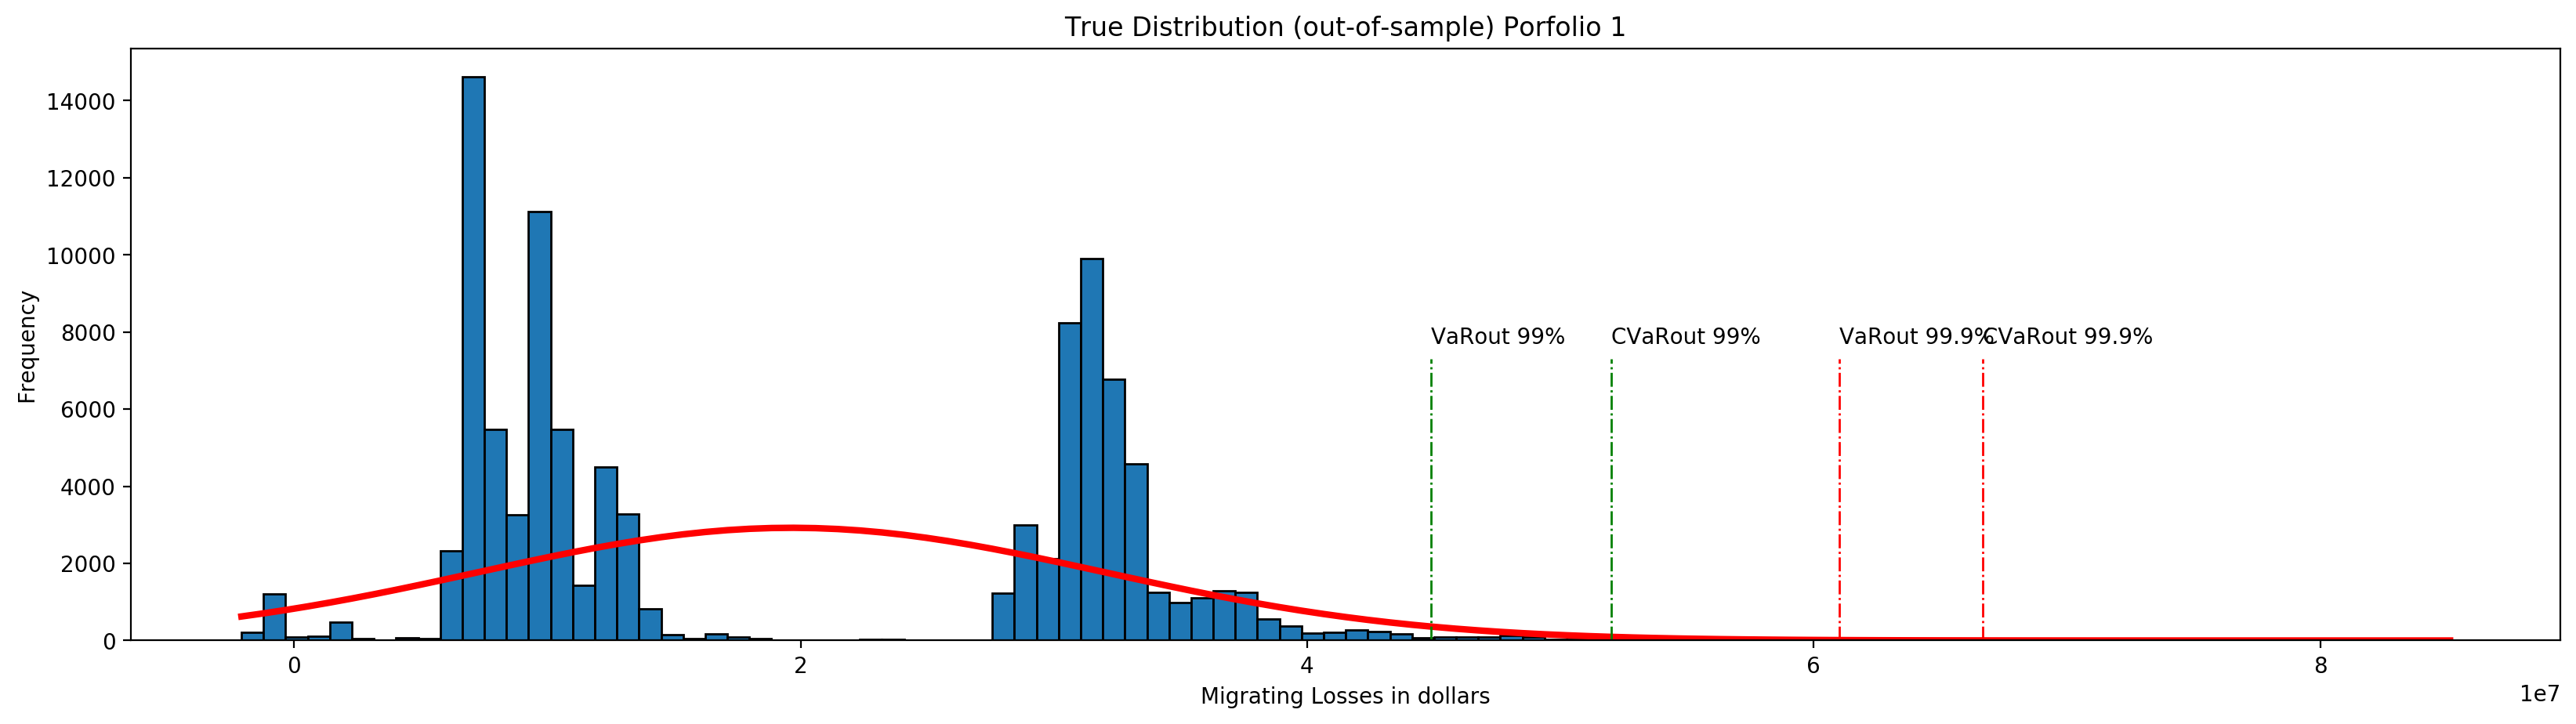

In [23]:
ax2 = plt.gca()
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 200
frequencyCounts, binLocations, patches = plt.hist(Losses_out_portf[:,0], 100, edgecolor = 'black')
normf = (1 / (np.std(Losses_out_portf[:,0]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(Losses_out_portf[:,0])) / np.std(Losses_out_portf[:,0])) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
ax2.plot(binLocations, normf, color='r', linewidth=3.0)
ax2.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts) / 2], color='g', linewidth=1, linestyle='-.')
ax2.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
ax2.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')
ax2.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
ax2.text(1 * VaRout[0,0], max(frequencyCounts) / 1.9, 'VaRout 99%')
ax2.text(1 * VaRout[0,1], max(frequencyCounts) / 1.9, 'VaRout 99.9%')
ax2.text(1 * CVaRout[0,0], max(frequencyCounts) / 1.9, 'CVaRout 99%')
ax2.text(1 * CVaRout[0,1], max(frequencyCounts) / 1.9, 'CVaRout 99.9%')
ax2.set_xlabel('Migrating Losses in dollars')
ax2.set_ylabel('Frequency')
ax2.set_title('True Distribution (out-of-sample) Porfolio 1')
plt.draw()

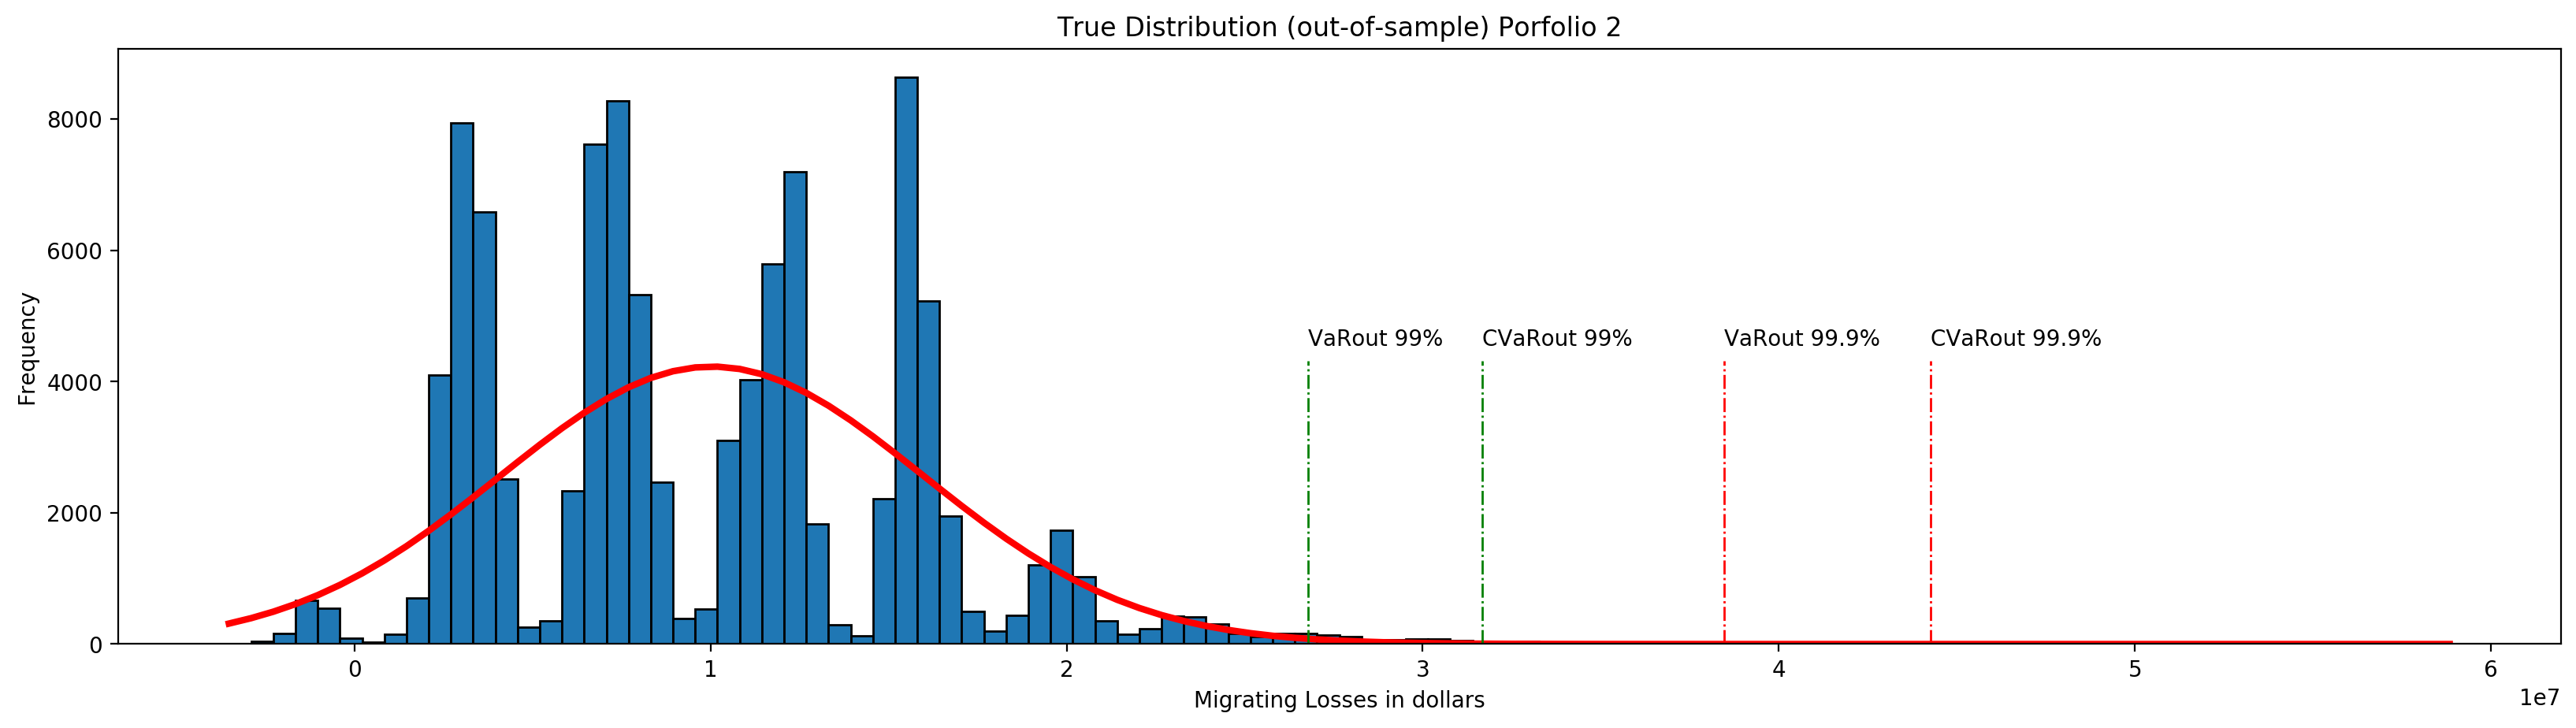

In [18]:
ax2 = plt.gca()
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 200
frequencyCounts, binLocations, patches = plt.hist(Losses_out_portf[:,1], 100, edgecolor = 'black')
normf = (1 / (np.std(Losses_out_portf[:,1]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(Losses_out_portf[:,1])) / np.std(Losses_out_portf[:,1])) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
ax2.plot(binLocations, normf, color='r', linewidth=3.0)
ax2.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts) / 2], color='g', linewidth=1, linestyle='-.')
ax2.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
ax2.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')
ax2.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
ax2.text(1 * VaRout[1,0], max(frequencyCounts) / 1.9, 'VaRout 99%')
ax2.text(1 * VaRout[1,1], max(frequencyCounts) / 1.9, 'VaRout 99.9%')
ax2.text(1 * CVaRout[1,0], max(frequencyCounts) / 1.9, 'CVaRout 99%')
ax2.text(1 * CVaRout[1,1], max(frequencyCounts) / 1.9, 'CVaRout 99.9%')
ax2.set_xlabel('Migrating Losses in dollars')
ax2.set_ylabel('Frequency')
ax2.set_title('True Distribution (out-of-sample) Porfolio 2')
plt.draw()

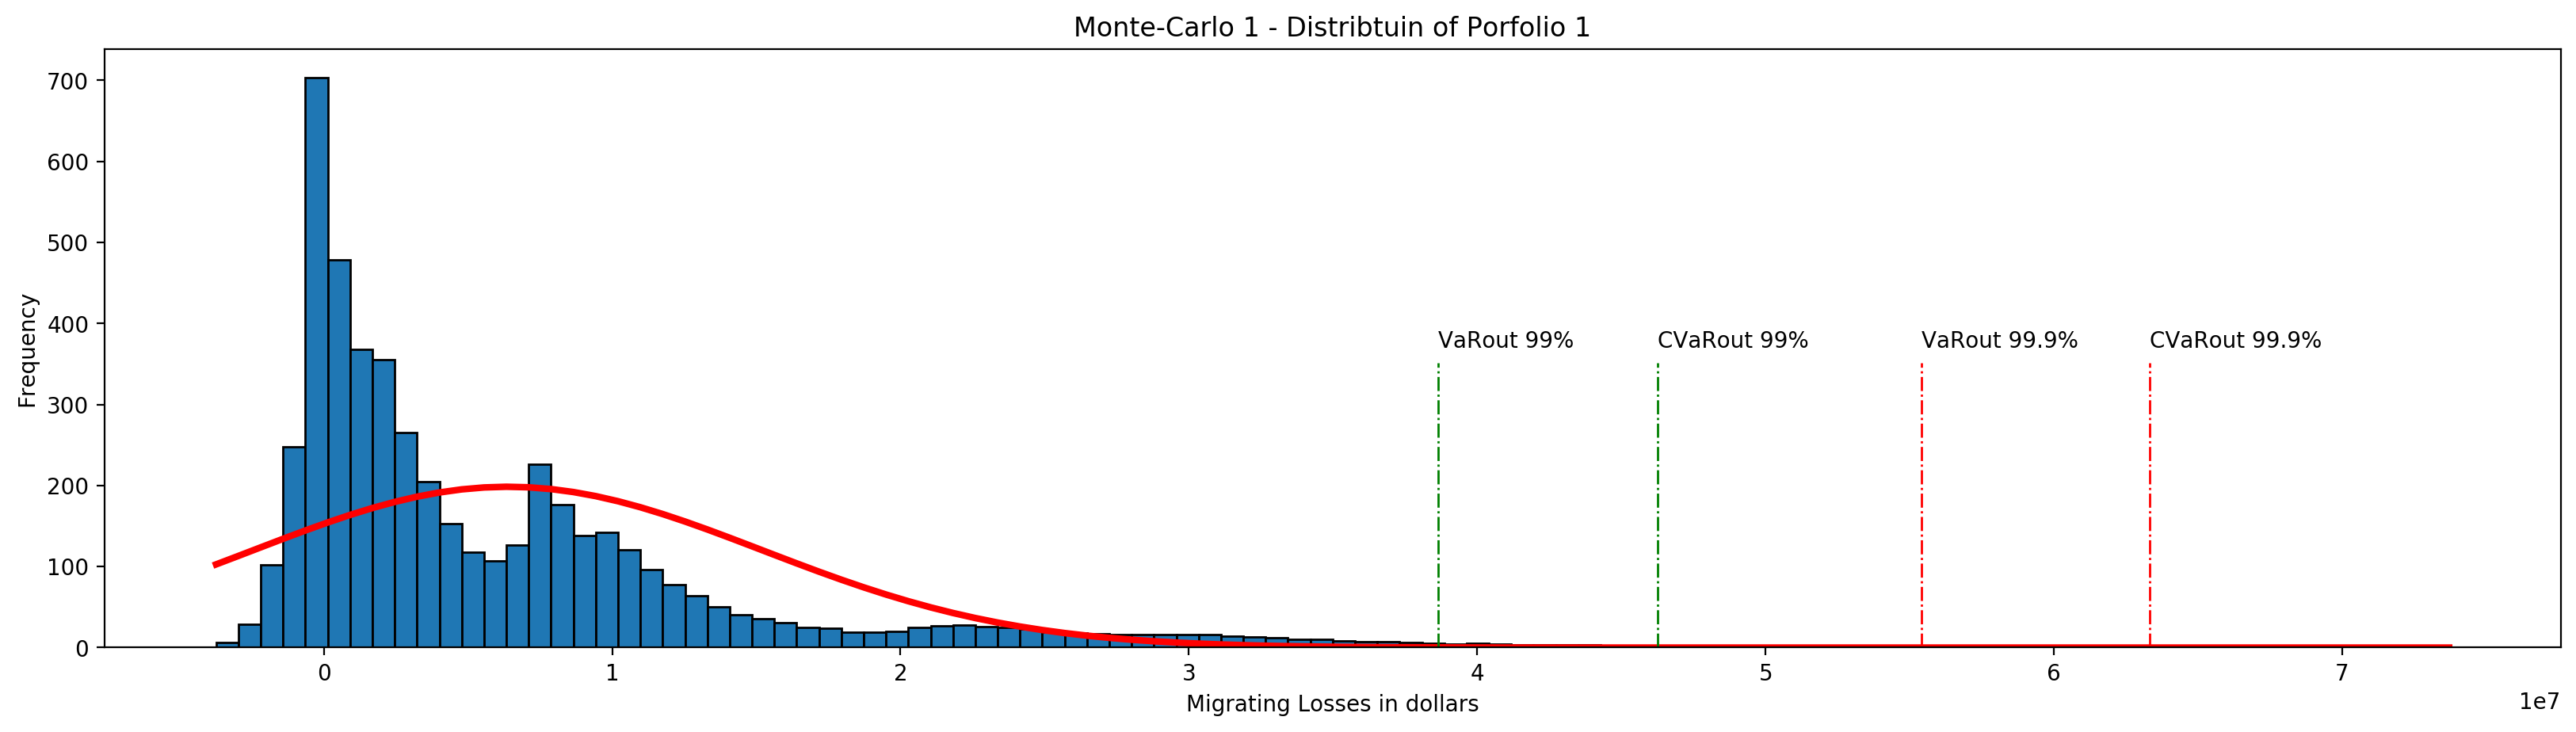

In [19]:
ax2 = plt.gca()
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 200
frequencyCounts, binLocations, patches = plt.hist(portf_loss_inMC1_portf1, 100, edgecolor = 'black')
normf = (1 / (np.std(portf_loss_inMC1_portf1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf_loss_inMC1_portf1)) / np.std(portf_loss_inMC1_portf1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
ax2.plot(binLocations, normf, color='r', linewidth=3.0)
ax2.plot([np.mean(VaRinMC1[0, 0]), np.mean(VaRinMC1[0, 0])], [0, max(frequencyCounts) / 2], color='g', linewidth=1, linestyle='-.')
ax2.plot([np.mean(VaRinMC1[0, 1]), np.mean(VaRinMC1[0, 1])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
ax2.plot([np.mean(CVaRinMC1[0, 0]), np.mean(CVaRinMC1[0, 0])], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')
ax2.plot([np.mean(CVaRinMC1[0, 1]), np.mean(CVaRinMC1[0, 1])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
ax2.text(1 * np.mean(VaRinMC1[0, 0]), max(frequencyCounts) / 1.9, 'VaRout 99%')
ax2.text(1 * np.mean(VaRinMC1[0, 1]), max(frequencyCounts) / 1.9, 'VaRout 99.9%')
ax2.text(1 * np.mean(CVaRinMC1[0, 0]), max(frequencyCounts) / 1.9, 'CVaRout 99%')
ax2.text(1 * np.mean(CVaRinMC1[0, 1]), max(frequencyCounts) / 1.9, 'CVaRout 99.9%')
ax2.set_xlabel('Migrating Losses in dollars')
ax2.set_ylabel('Frequency')
ax2.set_title('Monte-Carlo 1 - Distribtuin of Porfolio 1')
plt.draw()

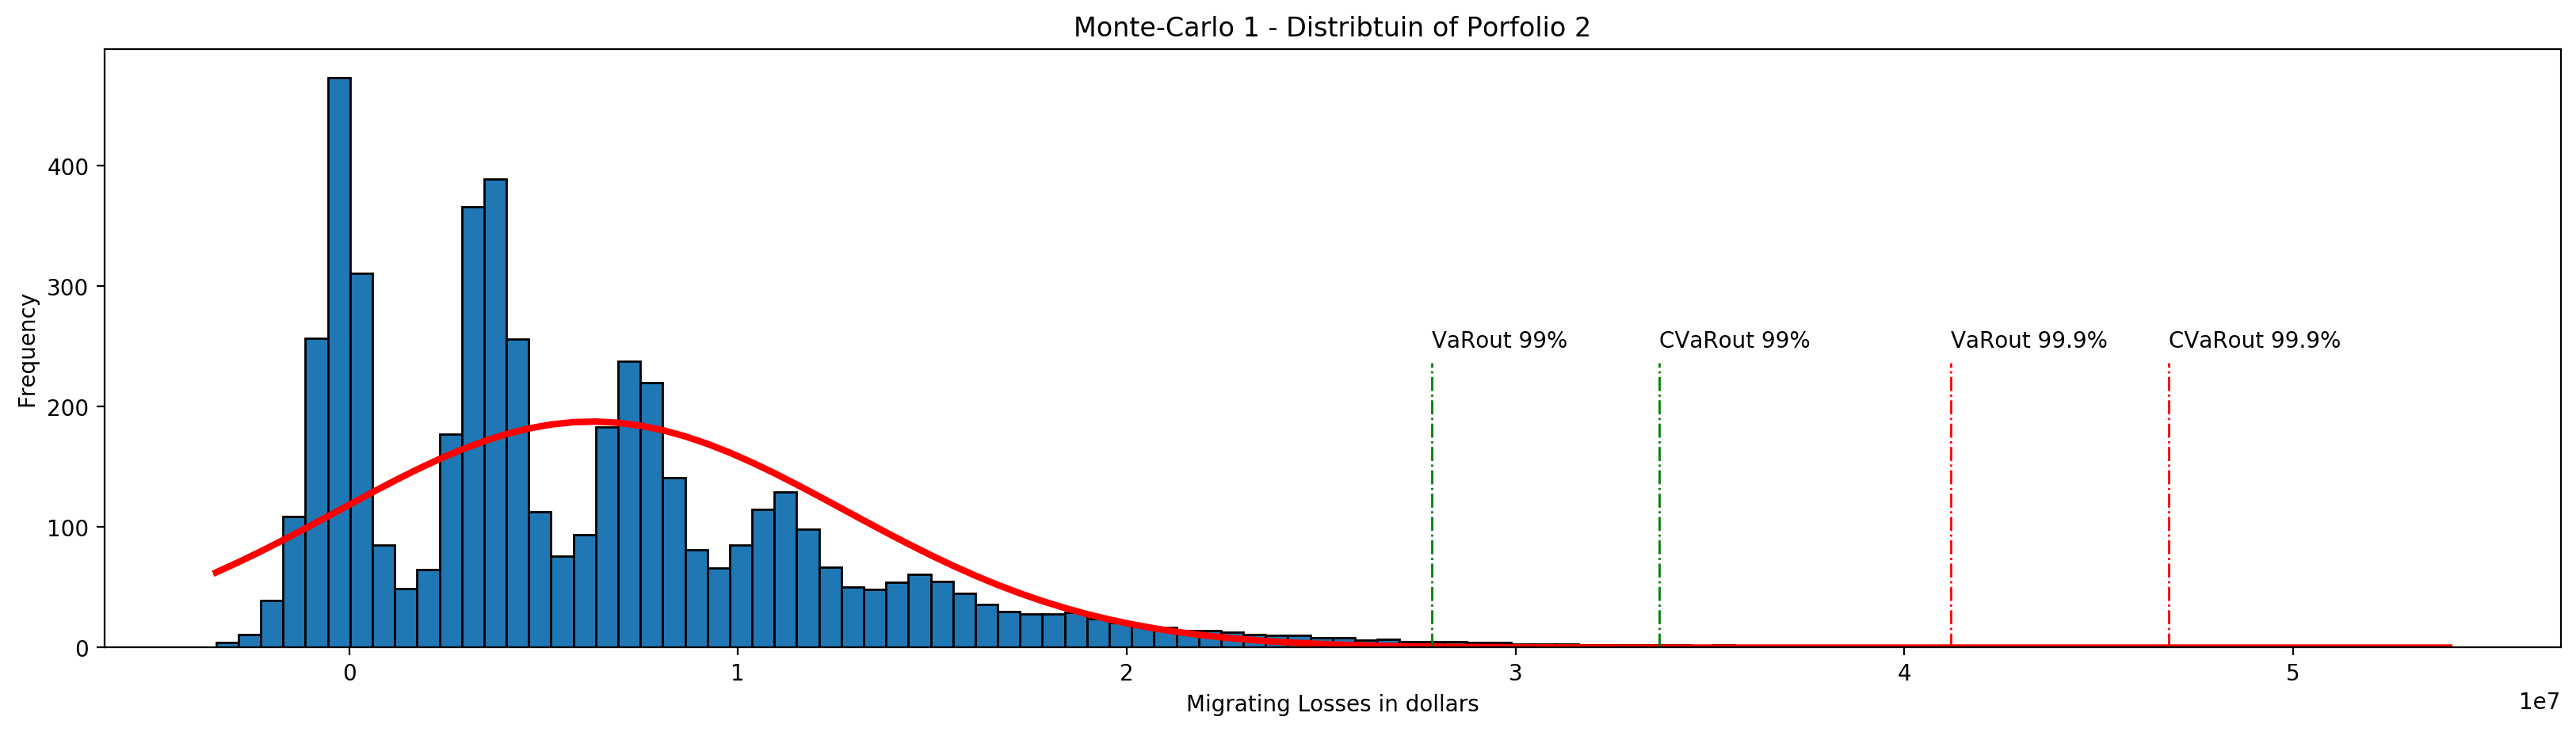

In [20]:
ax2 = plt.gca()
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 200
frequencyCounts, binLocations, patches = plt.hist(portf_loss_inMC1_portf2, 100, edgecolor = 'black')
normf = (1 / (np.std(portf_loss_inMC1_portf2) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf_loss_inMC1_portf2)) / np.std(portf_loss_inMC1_portf2)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
ax2.plot(binLocations, normf, color='r', linewidth=3.0)
ax2.plot([np.mean(VaRinMC1[1, 0]), np.mean(VaRinMC1[1, 0])], [0, max(frequencyCounts) / 2], color='g', linewidth=1, linestyle='-.')
ax2.plot([np.mean(VaRinMC1[1, 1]), np.mean(VaRinMC1[1, 1])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
ax2.plot([np.mean(CVaRinMC1[1, 0]), np.mean(CVaRinMC1[1, 0])], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')
ax2.plot([np.mean(CVaRinMC1[1, 1]), np.mean(CVaRinMC1[1, 1])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
ax2.text(1 * np.mean(VaRinMC1[1, 0]), max(frequencyCounts) / 1.9, 'VaRout 99%')
ax2.text(1 * np.mean(VaRinMC1[1, 1]), max(frequencyCounts) / 1.9, 'VaRout 99.9%')
ax2.text(1 * np.mean(CVaRinMC1[1, 0]), max(frequencyCounts) / 1.9, 'CVaRout 99%')
ax2.text(1 * np.mean(CVaRinMC1[1, 1]), max(frequencyCounts) / 1.9, 'CVaRout 99.9%')
ax2.set_xlabel('Migrating Losses in dollars')
ax2.set_ylabel('Frequency')
ax2.set_title('Monte-Carlo 1 - Distribtuin of Porfolio 2')
plt.draw()

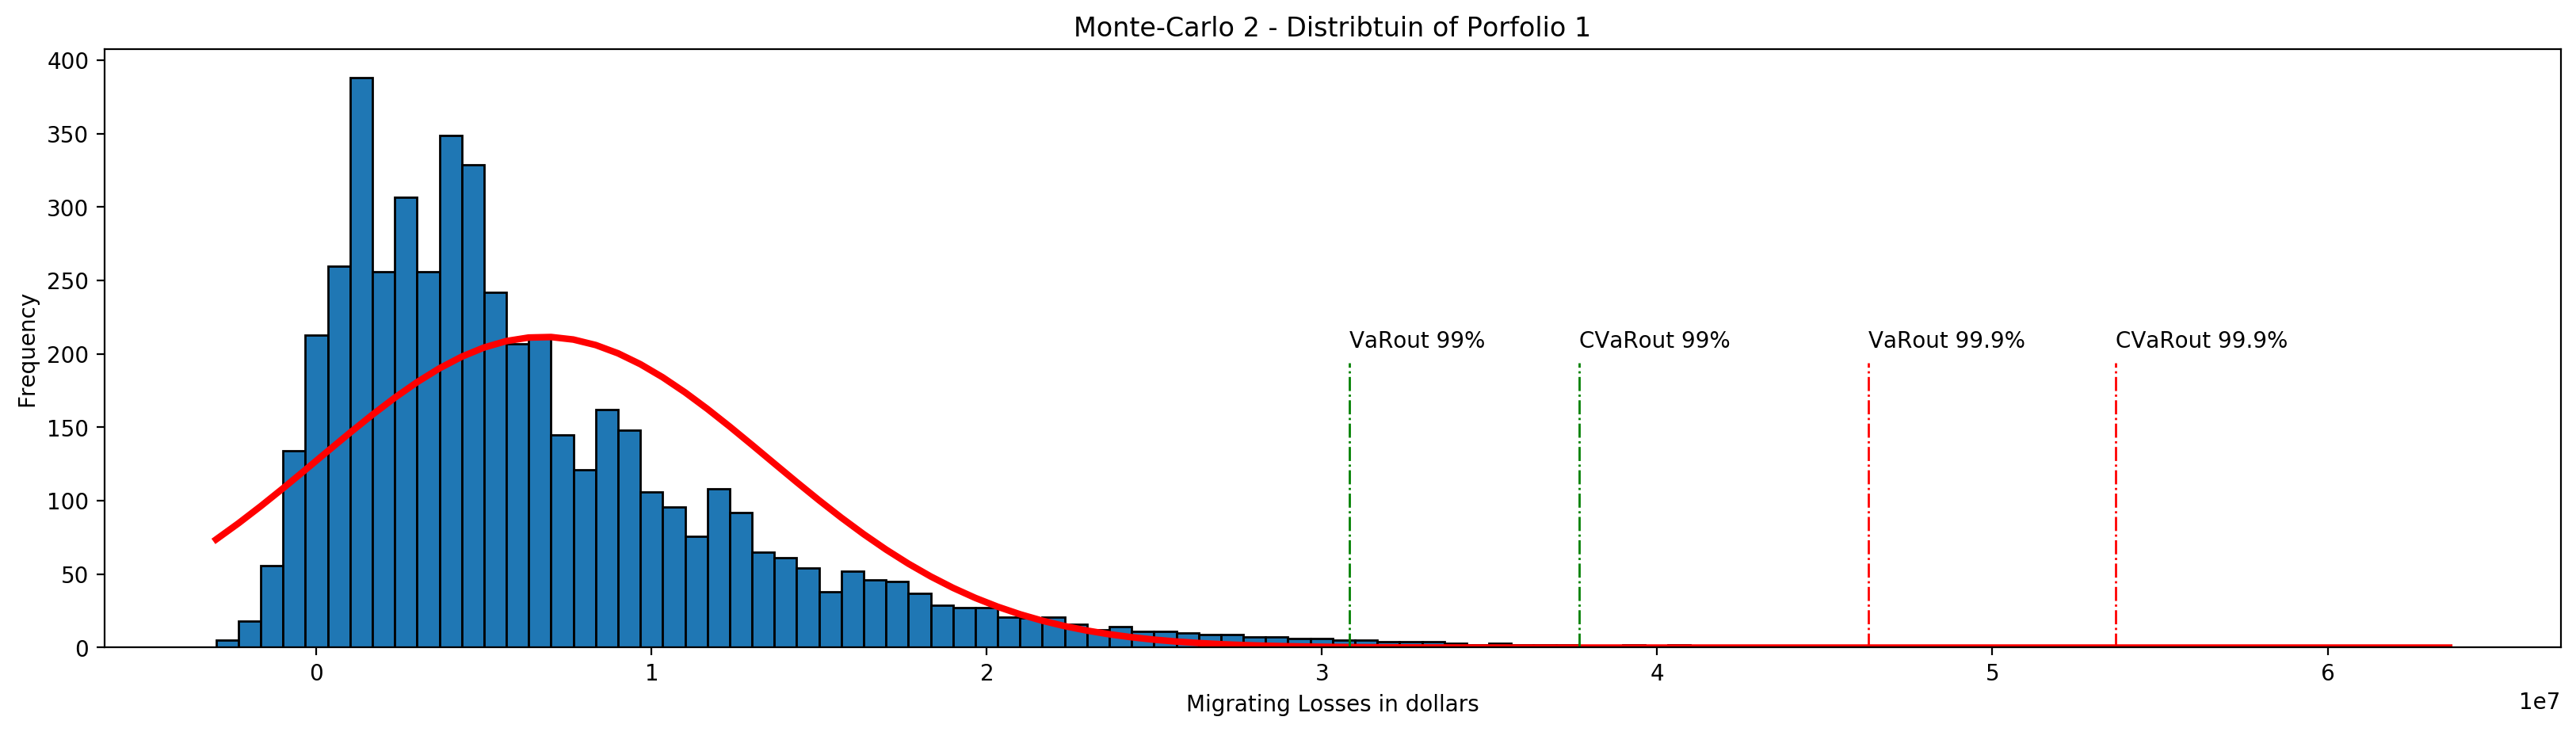

In [21]:
ax2 = plt.gca()
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 200
frequencyCounts, binLocations, patches = plt.hist(portf_loss_inMC2_portf1, 100, edgecolor = 'black')
normf = (1 / (np.std(portf_loss_inMC2_portf1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf_loss_inMC2_portf1)) / np.std(portf_loss_inMC2_portf1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
ax2.plot(binLocations, normf, color='r', linewidth=3.0)
ax2.plot([np.mean(VaRinMC2[0, 0]), np.mean(VaRinMC2[0, 0])], [0, max(frequencyCounts) / 2], color='g', linewidth=1, linestyle='-.')
ax2.plot([np.mean(VaRinMC2[0, 1]), np.mean(VaRinMC2[0, 1])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
ax2.plot([np.mean(CVaRinMC2[0, 0]), np.mean(CVaRinMC2[0, 0])], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')
ax2.plot([np.mean(CVaRinMC2[0, 1]), np.mean(CVaRinMC2[0, 1])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
ax2.text(1 * np.mean(VaRinMC2[0, 0]), max(frequencyCounts) / 1.9, 'VaRout 99%')
ax2.text(1 * np.mean(VaRinMC2[0, 1]), max(frequencyCounts) / 1.9, 'VaRout 99.9%')
ax2.text(1 * np.mean(CVaRinMC2[0, 0]), max(frequencyCounts) / 1.9, 'CVaRout 99%')
ax2.text(1 * np.mean(CVaRinMC2[0, 1]), max(frequencyCounts) / 1.9, 'CVaRout 99.9%')
ax2.set_xlabel('Migrating Losses in dollars')
ax2.set_ylabel('Frequency')
ax2.set_title('Monte-Carlo 2 - Distribtuin of Porfolio 1')
plt.draw()

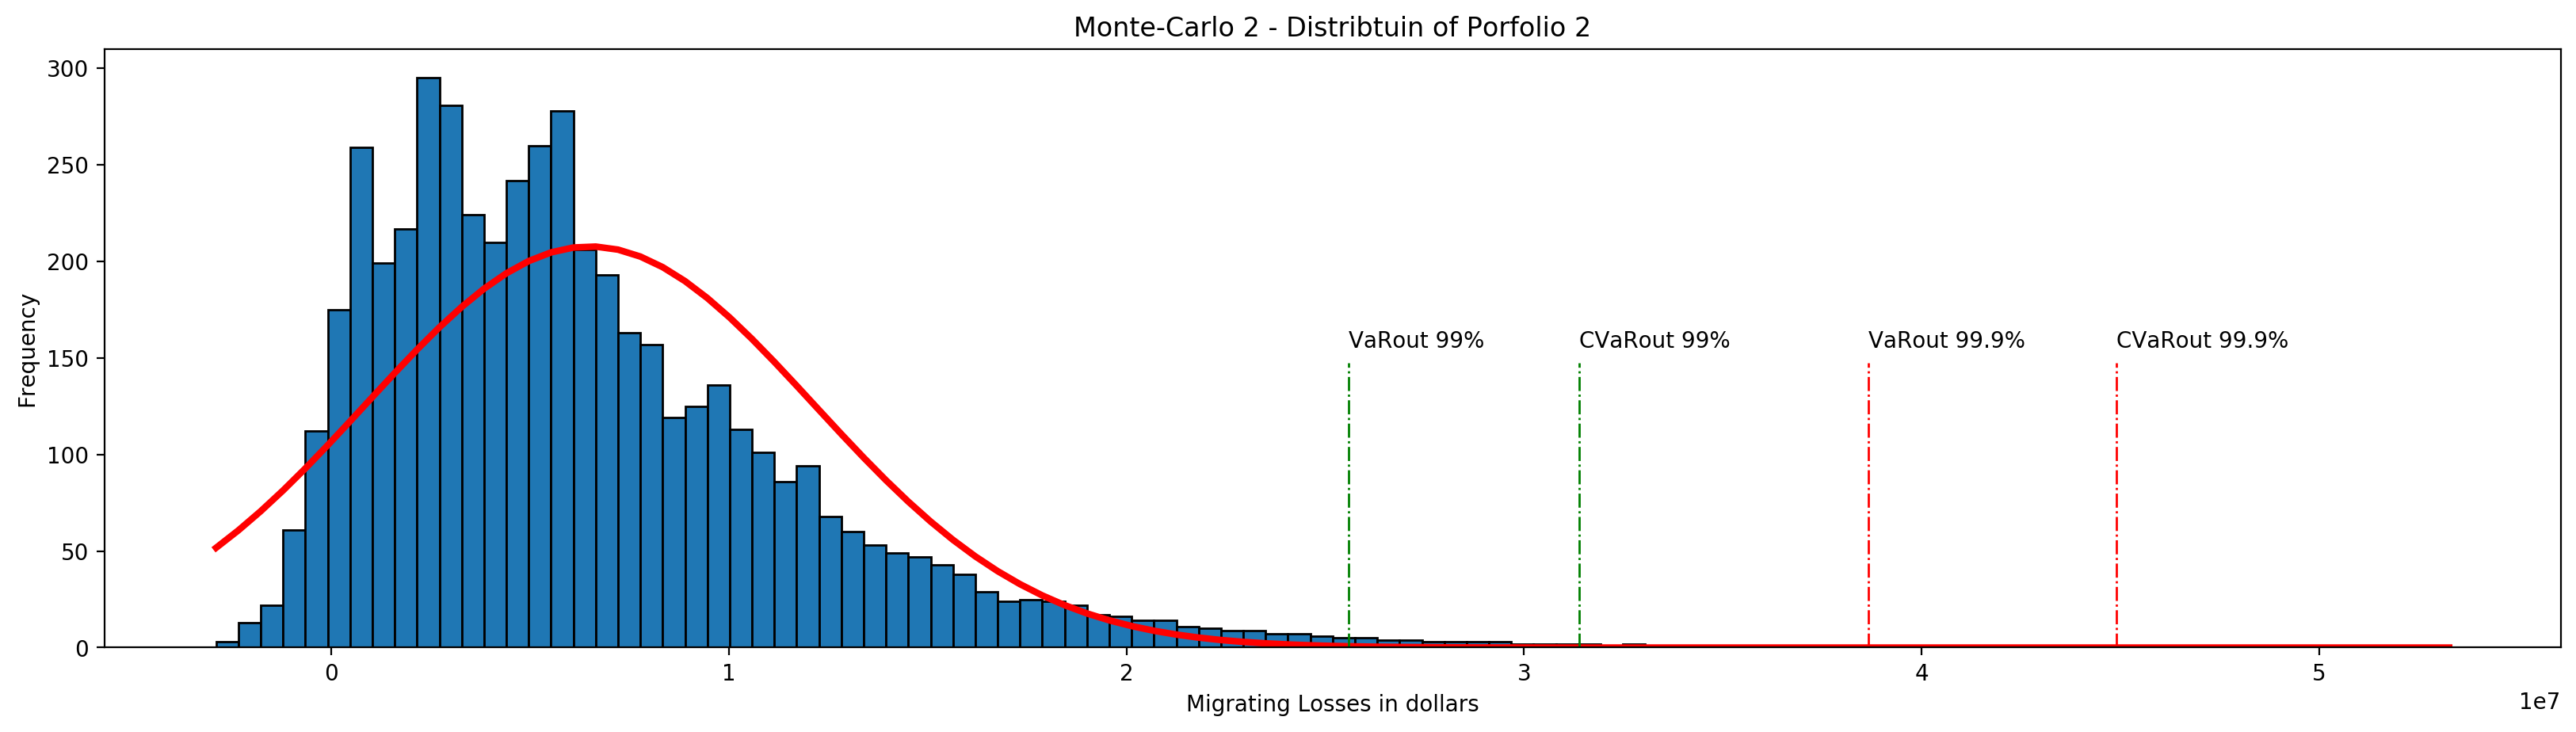

In [22]:
ax2 = plt.gca()
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 200
frequencyCounts, binLocations, patches = plt.hist(portf_loss_inMC2_portf2, 100, edgecolor = 'black')
normf = (1 / (np.std(portf_loss_inMC2_portf2) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf_loss_inMC2_portf2)) / np.std(portf_loss_inMC2_portf2)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
ax2.plot(binLocations, normf, color='r', linewidth=3.0)
ax2.plot([np.mean(VaRinMC2[1, 0]), np.mean(VaRinMC2[1, 0])], [0, max(frequencyCounts) / 2], color='g', linewidth=1, linestyle='-.')
ax2.plot([np.mean(VaRinMC2[1, 1]), np.mean(VaRinMC2[1, 1])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
ax2.plot([np.mean(CVaRinMC2[1, 0]), np.mean(CVaRinMC2[1, 0])], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')
ax2.plot([np.mean(CVaRinMC2[1, 1]), np.mean(CVaRinMC2[1, 1])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
ax2.text(1 * np.mean(VaRinMC2[1, 0]), max(frequencyCounts) / 1.9, 'VaRout 99%')
ax2.text(1 * np.mean(VaRinMC2[1, 1]), max(frequencyCounts) / 1.9, 'VaRout 99.9%')
ax2.text(1 * np.mean(CVaRinMC2[1, 0]), max(frequencyCounts) / 1.9, 'CVaRout 99%')
ax2.text(1 * np.mean(CVaRinMC2[1, 1]), max(frequencyCounts) / 1.9, 'CVaRout 99.9%')
ax2.set_xlabel('Migrating Losses in dollars')
ax2.set_ylabel('Frequency')
ax2.set_title('Monte-Carlo 2 - Distribtuin of Porfolio 2')
plt.draw()